<a href="https://colab.research.google.com/github/Madhavan7/Sentiment-Analysis-Fake-News-Detection/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers
!pip install contractions
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1XoHoUjZtLQ6gh_CPv9_igtZoEsdkgq3t

Downloading...
From: https://drive.google.com/uc?id=1XoHoUjZtLQ6gh_CPv9_igtZoEsdkgq3t
To: /content/news.csv
100% 30.7M/30.7M [00:00<00:00, 187MB/s]


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import pandas as pd
from transformers import BertModel
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from transformers import AutoTokenizer

root_dir = '/content/news.csv'
df =  pd.read_csv(root_dir)
df.head(5)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


**Dataset Preparation**

In [4]:

class ProcessText():
  def __init__(self):
    self.stemmer = PorterStemmer()
    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    self.model = BertModel.from_pretrained("bert-base-uncased")

  def get_vocab_size(self):
    return self.tokenizer.vocab_size

  def lemmatize(self, text):
    stemmer = PorterStemmer()
    text = text.lower()
    re.sub(r'\W+', ' ', text)
    t_array = [stemmer.stem(t) for t in text.split()]
    text = " ".join(t_array)
    return text

  def tokenize(self, texts):
    #returns the attention mask
    texts = self.batch_lemmatize(texts)
    tokens = self.tokenizer(texts, return_tensors="pt", padding='max_length', max_length=512, truncation=True)
    #need to fix below in order to give tokens not numbers
    return tokens['input_ids'], tokens['attention_mask']

  def tokenize_one_hot(self, texts):
    tokens, mask = self.tokenize(texts)
    return F.one_hot(tokens, self.tokenizer.vocab_size).to(torch.float32), mask


  def batch_lemmatize(self, texts):
    for i in range(len(texts)):
      texts[i] = self.lemmatize(texts[i])
    return texts

class WordEmbeddings(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(WordEmbeddings, self).__init__()
    self.embed = nn.Linear(vocab_size, embed_dim)
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def forward(self, x):
    return self.embed(x)

#Below we are debugging to see if the shapes of the output make sense
processor = ProcessText()
tokens, mask = processor.tokenize_one_hot(["Hello.   MY    name is @Madhav, and I am coding. I am 23 years old", "hello"])
print(mask.shape)
print(tokens.shape)
print(tokens.dtype)
model = WordEmbeddings(vocab_size = processor.get_vocab_size(), embed_dim = 768)
output = model(tokens)
print(output.shape)

tokens1, mask1 = processor.tokenize(["Hello.   MY    name is @Madhav, and I am coding. I am 23 years old"])
print(mask1.shape)
print(tokens1.shape)

torch.Size([2, 512])
torch.Size([2, 512, 30522])
torch.float32
torch.Size([2, 512, 768])
torch.Size([1, 512])
torch.Size([1, 512])


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
REAL = df.iloc[:,3] == "REAL"
FAKE = df.iloc[:,3] == "FAKE"
df["Real"] = REAL
df["Fake"] = FAKE
print(df.head(5))

train_val_set, test_set = train_test_split(df, train_size=0.8, stratify=df["Real"])
train_set, val_set = train_test_split(train_val_set, train_size=0.8, stratify=train_val_set["Real"])

print(len(train_set), len(val_set), len(test_set))

class Texts(Dataset):
  def __init__(self, df, root_dir, processor):
    self.df = df
    self.root_dir = root_dir
    self.processor = processor

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    text = self.df.iloc[index, 2]
    label = torch.tensor([int(self.df.iloc[index, 4]),int(self.df.iloc[index, 5])])
    return (text, label)

processor = ProcessText()

test_set1 = test_set.iloc[:100]
test_set2 = test_set.iloc[100:]

train_dataset = Texts(train_set, root_dir, processor)
val_dataset = Texts(val_set, root_dir, processor)
test_dataset = Texts(test_set, root_dir, processor)

test_dataset1 = Texts(test_set1, root_dir, processor)
test_dataset2 = Texts(test_set2, root_dir, processor)

batch_size = 8

train_dataloaders = {'train': DataLoader(train_dataset, batch_size = batch_size),
                     'val': DataLoader(val_dataset, batch_size=batch_size)}
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)



   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label   Real   Fake  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  False   True  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  False   True  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL   True  False  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  False   True  
4  It's primary day in New York and front-runners...  REAL   True  False  
4054 1014 1267


**Models**

In [6]:

#Below is a helper function that will help us compute the MultiHeadAttention
def attention(q, k, v, head_dim, mask = None):
  #Assumes the shape is batch_size*seq_length*embed_size*heads
  #multiplied by the transpose of that

  k = k.transpose(-3,-2)
  scores = torch.einsum("nijd,njkd->nikd",q,k)/math.sqrt(head_dim)

  #something about masking
  if mask is not None:
    mask = mask.unsqueeze(-1).unsqueeze(-1)
    scores = scores.masked_fill(mask == 0, -1e9)

  scores = F.softmax(scores, dim=-2)

  output = torch.einsum("nijd,njkd->nikd", scores, v)
  return output



class MSA(nn.Module):
  def __init__(self, embed_dim, heads, max_seq_len, dropout= None):
    super(MSA, self).__init__()

    #Size based parameters
    self.embed_dim = embed_dim
    self.heads = heads
    self.head_dim = self.embed_dim//heads
    assert(self.embed_dim % self.heads == 0)
    self.max_seq_len = max_seq_len

    self.q = nn.Linear(embed_dim, embed_dim)
    self.k = nn.Linear(embed_dim, embed_dim)
    self.v = nn.Linear(embed_dim, embed_dim)

    self.fc_out = nn.Linear(embed_dim, embed_dim)

  def forward(self, x, mask = None):
    #We assume x has shape batch_size*seq_length*embed_dim
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    batch_size = q.size(0)
    q = q.reshape(batch_size, self.max_seq_len, self.head_dim, self.heads)
    k = k.reshape(batch_size, self.max_seq_len, self.head_dim, self.heads)
    v = v.reshape(batch_size, self.max_seq_len, self.head_dim, self.heads)

    scores = attention(q,k,v, self.head_dim, mask)
    #stuff with concatenation
    #note that self.head_dim*self.heads = self.embed_dim
    scores = scores.reshape(batch_size, self.max_seq_len, self.embed_dim)
    scores = self.fc_out(scores)

    return scores

#Debugging to see if the sizes add up

q = torch.randn(5,3,4,6)
k = torch.randn(5,3,4,6)
v = torch.randn(5,3,4,6)

output = attention(q,k,v,6)
output1 = attention(q,k,v,6, mask=torch.ones(5,3))

print(output == output1)
print(output.shape)

model = MSA(embed_dim = 24, heads = 6, max_seq_len = 3)
input, mask = torch.randn(5,3,24), torch.ones(5,3)
output = model(input, mask)
print(output.shape)
#Output shape is same as input shape so we are good

tensor([[[[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]]],


        [[[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True,

In [7]:
class TransformerBlock(nn.Module):
  def __init__(self, embed_dim, heads, max_seq_len, forward_expansion, dropout = None):
    super(TransformerBlock, self).__init__()

    self.msa = MSA(embed_dim, heads, max_seq_len, dropout)
    self.norm1 = nn.LayerNorm(embed_dim)
    self.norm2 = nn.LayerNorm(embed_dim)

    self.feed_forward = nn.Sequential(
      nn.Linear(embed_dim, forward_expansion*embed_dim),
      nn.ReLU(),
      nn.Linear(forward_expansion*embed_dim, embed_dim)
    )

    self.dropout = nn.Dropout(dropout) if dropout else None

  def forward(self, x, mask = None):
    attention = self.msa(x,mask)
    x = self.dropout(self.norm1(attention + x))
    forward = self.feed_forward(x)
    out = self.dropout(self.norm2(forward + x))
    return out

class Encoder(nn.Module):
  def __init__(self,
               vocab_size,
               embed_dim,
               heads, device,
               max_seq_len,
               forward_expansion,
               num_layers,
               dropout = 0.5
               ):
    super(Encoder, self).__init__()
    #word and position embeddings
    self.max_seq_len = max_seq_len
    self.embed_dim = embed_dim
    self.device = device
    self.dropout = nn.Dropout(dropout)
    self.word_embedding = nn.Embedding(vocab_size, embed_dim)
    self.position_embedding = nn.Embedding(max_seq_len, embed_dim)

    self.layers = nn.ModuleList([
        TransformerBlock(embed_dim, heads, max_seq_len, forward_expansion, dropout)

        for _ in range(num_layers)
    ])

    self.classifier = nn.Linear(max_seq_len*embed_dim, 2)
    self.softmax = nn.Softmax(dim = 1)

  def forward(self, x, mask):
    batch_size, _ = x.shape
    positions = torch.arange(0, self.max_seq_len).expand(batch_size, self.max_seq_len).to(self.device)
    out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )
    for layer in self.layers:
        out = layer(out, mask)
    out = out.flatten(start_dim=1)
    out = self.classifier(out)
    out = self.softmax(out)
    return out

#simple debugging to see if size matches up
processor = ProcessText()
tokens, mask = processor.tokenize(["Hello.   MY    name is @Madhav, and I am coding. I am 23 years old", "hello", "what", "why"])
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
tokens, mask = tokens.to(device), mask.to(device)
encoder = Encoder(processor.get_vocab_size(), 768, 2, device, 512, 3, 2)
encoder.to(device)
output = encoder(tokens, mask)
print(tokens.shape, mask.shape)
print(output.shape)

torch.Size([4, 512]) torch.Size([4, 512])
torch.Size([4, 2])


**Training and Testing**

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def visualize(*args, labels):
  n = len(args[0])
  x = np.arange(0,n, 1)
  assert len(args) == len(labels), "Each list must have a corresponding label"
  #Defining the functions used for plotting
  for i in range(len(args)):
    assert len(args[i]) == n, "incorrect number of values"
    plt.plot(x, args[i], label = labels[i])
  plt.xlim(0,n-1)
  plt.xticks(range(0,n-1))
  plt.ylim(0,1)
  plt.title("Model Evaluation")
  plt.xlabel("Epochs")
  plt.ylabel("Metrics")
  plt.legend()
  plt.show()

def visualize_training(*args):
  labels = ["Precision", "Recall", "F1", "Specificity"]
  visualize(*args, labels= labels)

In [9]:
from numpy import mean
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score


def training_loop(dataloader, model, epochs, loss_function, optimizer, processor, scheduler = None):
  epoch_losses = []
  epoch_precisions = []
  epoch_recalls = []
  epoch_f1_scores = []
  epoch_specificities = []
  for epoch in range(epochs):
    print("Epoch: " + str(epoch))
    batch_tn = []
    batch_fp = []
    batch_tp = []
    batch_fn = []
    batch_losses = []
    for x in ['train', 'val']:
      model.to(device)
      if x == 'train':
        model.train()
      else:
        model.eval()
      for (data, label) in dataloader[x]:
        data = list(data)
        tokens, mask = processor.tokenize(data)
        tokens, mask = tokens.to(device), mask.to(device)
        label = label.to(torch.float32).to(device)
        output = model(tokens, mask)
        ###
        output.to(device)
        loss = loss_function(output, label)
        optimizer.zero_grad()
        with torch.no_grad():
          predictions = torch.argmax(output.to('cpu'), 1)
          label = torch.argmax(label.to('cpu'), 1)
          tn, fp, fn, tp = confusion_matrix(label, predictions, labels=[0,1]).ravel()

        if x == 'train':
          loss.backward()
          optimizer.step()
        else:
          batch_losses.append(loss.item())
          batch_tn.append(tn)
          batch_fp.append(fp)
          batch_tp.append(tp)
          batch_fn.append(fn)

    epoch_loss = mean(batch_losses)
    epoch_losses.append(epoch_loss)
    epoch_tn, epoch_fp, epoch_tp, epoch_fn = sum(batch_tn), sum(batch_fp), sum(batch_tp), sum(batch_fn)

    if scheduler:
        scheduler.step(epoch_loss)

    epoch_precision = epoch_tp/(epoch_tp + epoch_fp) if epoch_tp + epoch_fp != 0 else 0
    epoch_precisions.append(epoch_precision)
    epoch_recall = epoch_tp/(epoch_tp + epoch_fn) if epoch_tp + epoch_fp != 0 else 1
    epoch_recalls.append(epoch_recall)
    epoch_f1 = (2*epoch_recall*epoch_precision)/(epoch_recall + epoch_precision) if epoch_recall + epoch_precision != 0 else 0
    epoch_f1_scores.append(epoch_f1)
    epoch_specificity = epoch_tn/(epoch_tn + epoch_fp) if epoch_tn + epoch_fp != 0 else 1
    epoch_specificities.append(epoch_specificity)

    print("Precision: " + str(epoch_precision)
          + " F1: " + str(epoch_f1))
    print("Recall: " + str(epoch_recall) + " Specificity: " + str(epoch_specificity))
    print("Loss: " + str(epoch_loss))

  return [epoch_precisions, epoch_recalls, epoch_f1_scores, epoch_specificities]

Epoch: 0
Precision: 0.7083333333333334 F1: 0.53125
Recall: 0.425 Specificity: 0.825
Loss: 1.5190224189311266
Epoch: 1
Precision: 0.7021276595744681 F1: 0.5196850393700788
Recall: 0.4125 Specificity: 0.825
Loss: 1.8946438484359533
Epoch: 2
Precision: 0.7741935483870968 F1: 0.4324324324324324
Recall: 0.3 Specificity: 0.9125
Loss: 2.499570394633338
Epoch: 3
Precision: 0.7441860465116279 F1: 0.5203252032520326
Recall: 0.4 Specificity: 0.8625
Loss: 2.919288622163731
Epoch: 4
Precision: 0.7714285714285715 F1: 0.4695652173913044
Recall: 0.3375 Specificity: 0.9
Loss: 3.6389738219202625
Epoch: 5
Precision: 0.7317073170731707 F1: 0.4958677685950414
Recall: 0.375 Specificity: 0.8625
Loss: 2.783369565293833
Epoch: 6
Precision: 0.7567567567567568 F1: 0.4786324786324787
Recall: 0.35 Specificity: 0.8875
Loss: 2.3932232827704865
Epoch: 7
Precision: 0.7142857142857143 F1: 0.4918032786885245
Recall: 0.375 Specificity: 0.85
Loss: 2.9978781695710497
Epoch: 8
Precision: 0.7446808510638298 F1: 0.55118110236

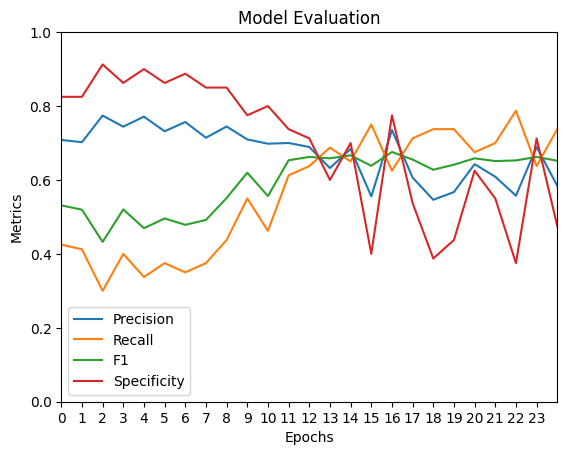

In [ ]:
import torch.optim as optim

processor = ProcessText()
lr = 5e-5
vocab_size = processor.get_vocab_size()
embed_dim = 512
heads = 8
num_layers = 6
forward_expansion = 4
max_seq_len = 512
dropout = 0.3

model = Encoder(vocab_size=vocab_size, embed_dim=embed_dim, device = device,heads=heads, num_layers=num_layers, forward_expansion=forward_expansion, max_seq_len=max_seq_len, dropout=dropout)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.6)

epochs = 25
args = training_loop(train_dataloaders, model, epochs, loss_function, optimizer, processor, scheduler)
visualize_training(*args)

Lets test the model

In [ ]:
import itertools
from tabulate import tabulate

def test(test_dataloader, model):
  model.to(device)
  labels = []
  predictions = []
  model.eval()
  #Assumes that batch_size = len(test_dataloader)
  for data, label in test_dataloader:
    data = list(data)
    tokens, mask = processor.tokenize(data)
    tokens, mask = tokens.to(device), mask.to(device)
    label = label.to(torch.float32).to(device)
    output = model(tokens, mask)
    with torch.no_grad():
      batch_predictions = torch.argmax(output.to('cpu'), 1)
      batch_label = torch.argmax(label.to('cpu'), 1)
      labels.extend(batch_label)
      predictions.extend(batch_predictions)
  return confusion_matrix(labels, predictions, labels=[0,1]), classification_report(labels, predictions, output_dict=True)

def visualize_testing(cm):
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, [0,1], rotation=45)
  plt.yticks(tick_marks, [0,1])
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')



[[64 36]
 [13 87]]
╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label   │   Precision │   Recall │   F1-score │   Support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Real    │    0.831169 │     0.64 │   0.723164 │       100 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│ Fake    │    0.707317 │     0.87 │   0.780269 │       100 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛


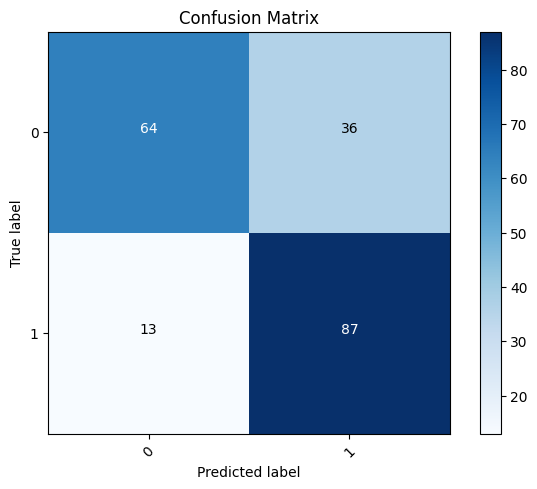

In [ ]:
torch.cuda.empty_cache()
cm, cr = test(test_dataloader, model)
visualize_testing(cm)
data = {"Label": ["Real", "Fake"], "Precision": [cr['0']['precision'], cr['1']['precision']], "Recall": [cr['0']['recall'], cr['1']['recall']],
        "F1-score":[cr['0']['f1-score'], cr['1']['f1-score']], "Support": [cr['0']['support'], cr['1']['support']]}
print(tabulate(data, headers="keys", tablefmt="fancy_grid"))

The results from this model are pretty good. However, lets try a pretrained model to see if we can get even better results.

In [19]:
class FineTunedModel(nn.Module):
  def __init__(self, num_classes):
    super(FineTunedModel, self).__init__()
    self.model = BertModel.from_pretrained('bert-base-uncased')
    self.classifier = nn.Linear(768, num_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    output = self.model(input_ids=input_ids, attention_mask=attention_mask).logits
    output = self.classifier(output)
    return output

In [20]:
import torch.optim as optim

processor = ProcessText()
model = FineTunedModel(num_classes=2)
model = model.to(device)

lr = 5e-5
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.6)

epochs = 25
args = training_loop(train_dataloaders, model, epochs, loss_function, optimizer, processor, scheduler)
visualize_training(*args)

RuntimeError: ignored